# Import Libraries

In [51]:
import os
import cv2
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from tensorflow.keras import layers, optimizers
from keras.optimizers import RMSprop
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [52]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [53]:
%cd /content/drive/MyDrive/Data Science Portfolio/Chest X-Ray Disease Classification Model/

/content/drive/MyDrive/Data Science Portfolio/Chest X-Ray Disease Classification Model


# Load Data

In [54]:
XRay_Directory = '/content/drive/My Drive/Data Science Portfolio/Chest X-Ray Disease Classification Model/Dataset'

In [55]:
os.listdir(XRay_Directory)

['3', '1', '0', '2']

In [56]:
# create image generator & rescale images
# use 20% of data for cross-validation
image_generator = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

In [57]:
# shuffling and image resizing
train_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="training")

Found 428 images belonging to 4 classes.


In [58]:
validation_generator = image_generator.flow_from_directory(batch_size = 40, directory= XRay_Directory, shuffle= True, target_size=(256,256), class_mode = 'categorical', subset="validation")

Found 104 images belonging to 4 classes.


In [59]:
# generate batch of 40 images and labels
train_images, train_labels = next(train_generator)

In [60]:
train_images.shape

(40, 256, 256, 3)

In [61]:
train_labels.shape

(40, 4)

In [62]:
# label mapping
label_names = {0 : 'Covid-19', 1 : 'Normal' , 2: 'Viral Pneumonia', 3 : 'Bacterial Pneumonia'}

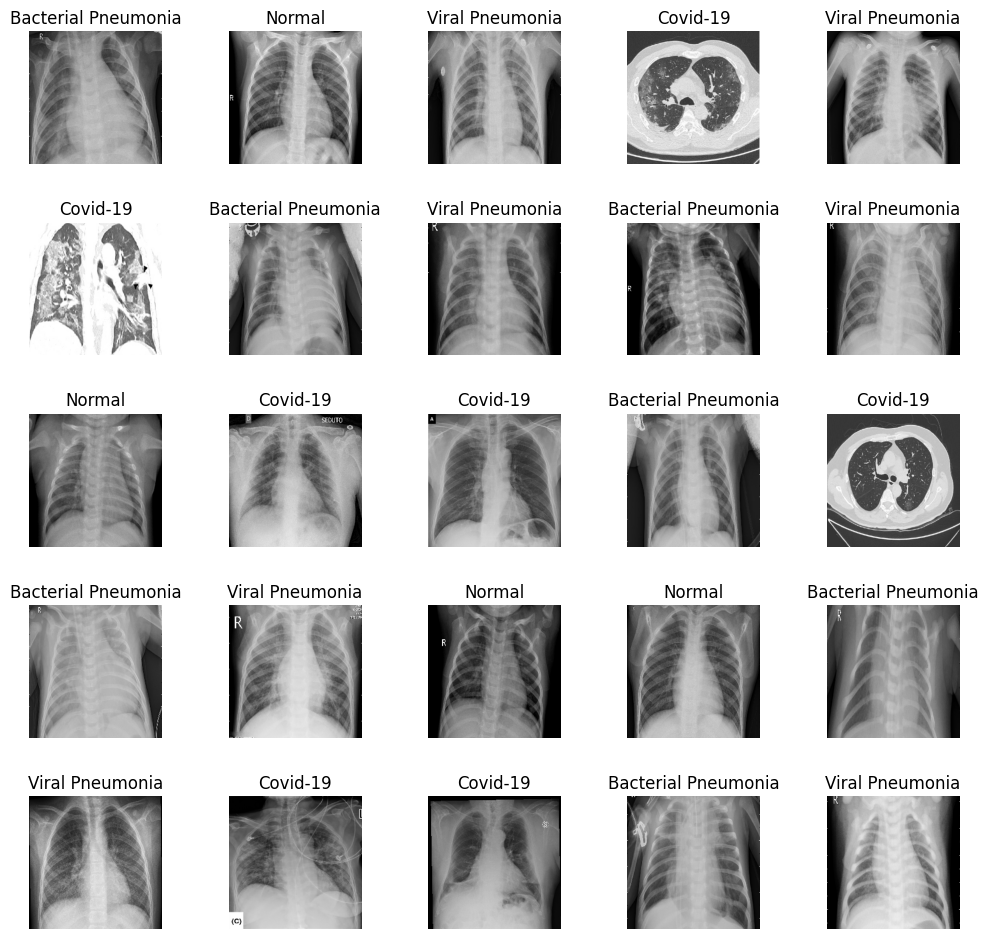

In [63]:
# visualize images
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize = (12, 12))
axes = axes.ravel()

for i in np.arange(0, L*W):
    axes[i].imshow(train_images[i])
    axes[i].set_title(label_names[np.argmax(train_labels[i])])
    axes[i].axis('off')

plt.subplots_adjust(wspace = 0.5)


# Transfer Learning

In [64]:
basemodel = ResNet50(include_top = False, weights= 'imagenet', input_shape = (256, 256, 3))

In [65]:
basemodel.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 262, 262, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 128, 128, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 128, 128, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [66]:
# freeze the last 10 layers
for layer in basemodel.layers[:-10]:
  layer.trainable = False

# Build Model

In [67]:
headmodel = basemodel.output
headmodel = AveragePooling2D(pool_size = (4,4))(headmodel)
headmodel = Flatten()(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(256, activation = 'relu')(headmodel)
headmodel = Dropout(0.3)(headmodel)
headmodel = Dense(4, activation = 'softmax')(headmodel)

In [68]:
# creating final model with base model inputs and head model outputs

model = Model(inputs = basemodel.inputs , outputs = headmodel)

In [83]:
model.compile(optimizer = RMSprop(learning_rate = 1e-6), loss = 'categorical_crossentropy' , metrics = ['accuracy'])

In [70]:
earlystopping = EarlyStopping(monitor = 'val_loss', verbose = 1, patience = 20, mode = 'min')

checkpointer = ModelCheckpoint(filepath = 'model_weights.hdf5', save_best_only = True, verbose = 1 )

In [71]:
train_generator = image_generator.flow_from_directory(batch_size = 4, directory = XRay_Directory, shuffle = True, target_size = (256,256), class_mode = 'categorical', subset = "training")

Found 428 images belonging to 4 classes.


In [72]:
validation_generator = image_generator.flow_from_directory(batch_size = 4, directory = XRay_Directory, shuffle = True, target_size = (256,256), class_mode = 'categorical', subset = "validation")

Found 104 images belonging to 4 classes.


In [73]:
# training the model
history = model.fit_generator(train_generator, steps_per_epoch = train_generator.n // 4, epochs = 250, validation_data = validation_generator, callbacks = [earlystopping, checkpointer])

Epoch 1/250


<ipython-input-73-ff9fba39e056>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_generator, steps_per_epoch = train_generator.n // 4, epochs = 250, validation_data = validation_generator, callbacks = [earlystopping, checkpointer])


107/107 [==============================] - ETA: 0s - loss: 1.6999 - accuracy: 0.2593
Epoch 1: val_loss improved from inf to 1.64724, saving model to model_weights.hdf5
107/107 [==============================] - 15s 101ms/step - loss: 1.6999 - accuracy: 0.2593 - val_loss: 1.6472 - val_accuracy: 0.2500
Epoch 2/250
107/107 [==============================] - ETA: 0s - loss: 1.4782 - accuracy: 0.2991
Epoch 2: val_loss improved from 1.64724 to 1.44308, saving model to model_weights.hdf5
107/107 [==============================] - 10s 95ms/step - loss: 1.4782 - accuracy: 0.2991 - val_loss: 1.4431 - val_accuracy: 0.2500
Epoch 3/250
107/107 [==============================] - ETA: 0s - loss: 1.3678 - accuracy: 0.3435
Epoch 3: val_loss improved from 1.44308 to 1.37782, saving model to model_weights.hdf5
107/107 [==============================] - 10s 95ms/step - loss: 1.3678 - accuracy: 0.3435 - val_loss: 1.3778 - val_accuracy: 0.2500
Epoch 4/250
107/107 [==============================] - ETA: 0s -

In [74]:
# saving model architecture
model_json = model.to_json()
with open("model.json", "w") as json_file:
  json_file.write(model_json)

# Evaluate Model

In [75]:
with open('model.json', 'r') as json_file:
    json_savedModel= json_file.read()

# load model architecture
model = tf.keras.models.model_from_json(json_savedModel)
# load model weight
model.load_weights('model_weights.hdf5')

In [76]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

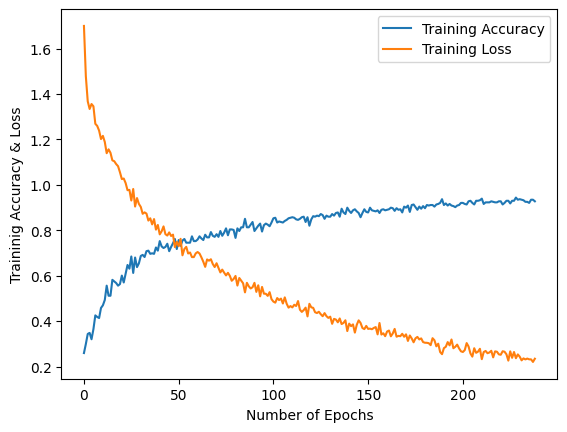

In [77]:
# plotting training accuracy & training loss
plt.plot(history.history['accuracy'], label = 'Training Accuracy')
plt.plot(history.history['loss'], label = 'Training Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Traininig Accuracy & Loss')
plt.legend()

Text(0, 0.5, 'Validation Loss')

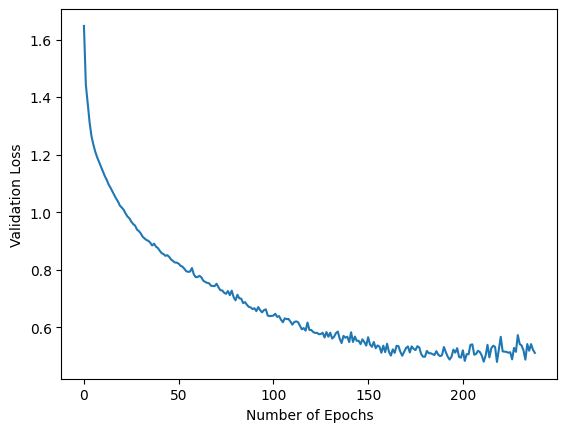

In [78]:
# plotting validation loss
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Number of Epochs')
plt.ylabel('Validation Loss')

Text(0, 0.5, 'Validation Accuracy')

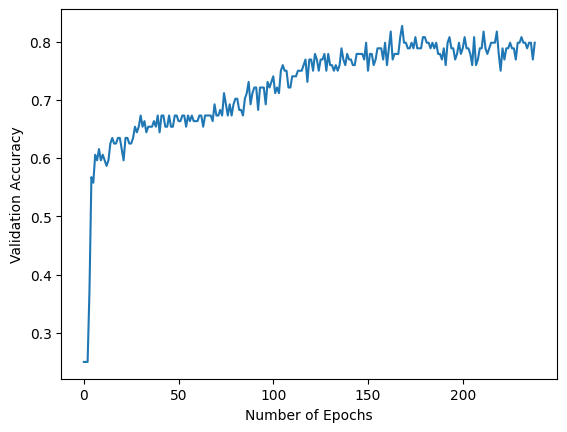

In [79]:
# plotting validation accuracy
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Number of Epochs')
plt.ylabel('Validation Accuracy')

# Test Model

In [80]:
test_directory = '/content/drive/My Drive/Data Science Portfolio/Chest X-Ray Disease Classification Model/Test'

In [84]:
# creating image data generator for testing
test_gen = ImageDataGenerator(rescale = 1./255)
# Creating test data generator
test_generator = test_gen.flow_from_directory(batch_size = 4, directory= test_directory, shuffle= True, target_size=(256,256), class_mode = 'categorical')
# evaluating the model on test data
evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4 , verbose = 1)

Found 40 images belonging to 4 classes.


<ipython-input-84-24ed0bde1688>:6: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  evaluate = model.evaluate_generator(test_generator, steps = test_generator.n // 4 , verbose = 1)


10/10 [==============================] - 11s 1s/step - loss: 0.7437 - accuracy: 0.7500


In [85]:
print(f"Accuracy Test : {evaluate[1]}")

Accuracy Test : 0.75


In [86]:
# predicted labels
prediction = []
# true labels
original = []
image = []

for i in range(len(os.listdir(test_directory))):
  for item in os.listdir(os.path.join(test_directory,str(i))):
        # reading test images
        img= cv2.imread(os.path.join(test_directory,str(i),item))
        # resizing images
        img = cv2.resize(img,(256,256))
        image.append(img)
        img = img / 255
        # reshaping images
        img = img.reshape(-1,256,256,3)
        # making predictions
        predict = model.predict(img)
        #  getting predicted class index
        predict = np.argmax(predict)
        prediction.append(predict)
        original.append(i)

1/1 [==============================] - 0s 23ms/step


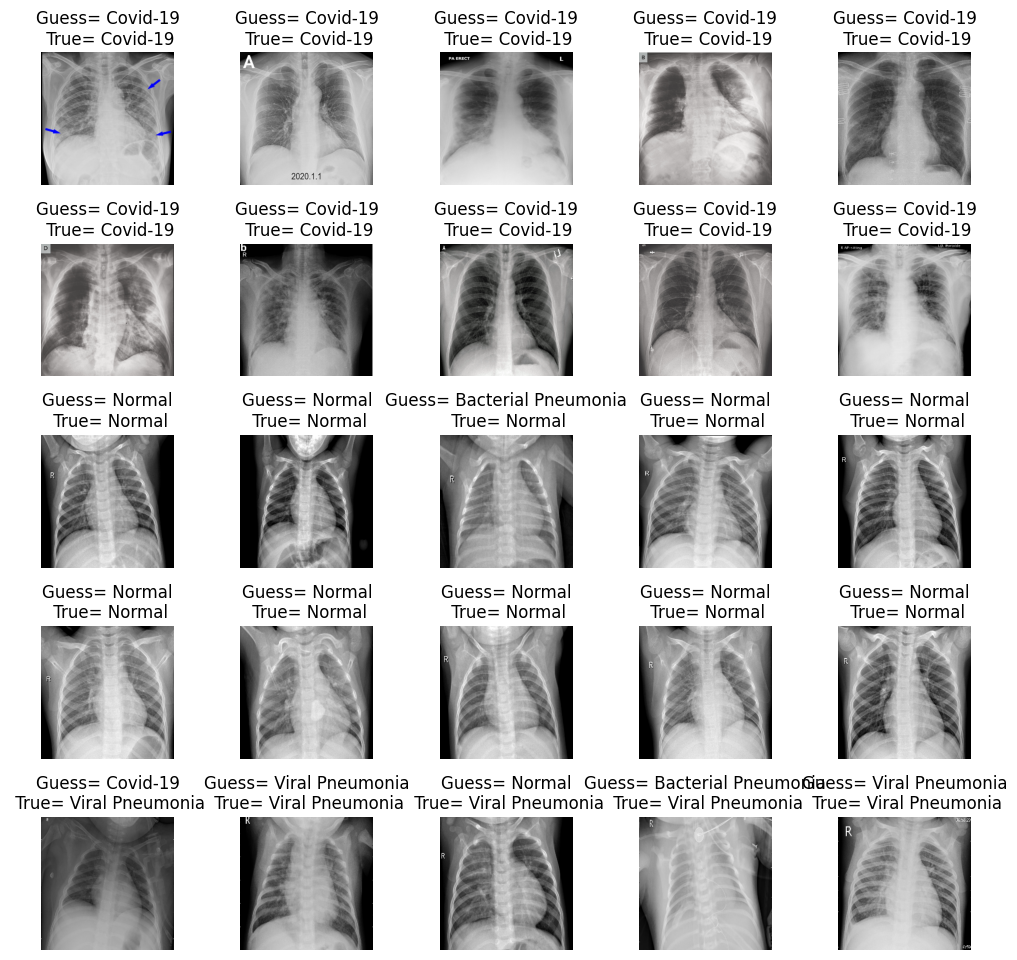

In [87]:
L = 5
W = 5

fig, axes = plt.subplots(L, W, figsize=(12, 12))
axes = axes.ravel()

for i in range(0, L*W):
    axes[i].imshow(image[i])
    axes[i].set_title(f"Guess= {str(label_names[prediction[i]])}\n True= {str(label_names[original[i]])}")
    axes[i].axis('off')

plt.subplots_adjust(wspace=0.5)

In [88]:
# printing classification report
print(classification_report(np.asarray(original), np.asarray(prediction)))

              precision    recall  f1-score   support

           0       0.77      1.00      0.87        10
           1       0.69      0.90      0.78        10
           2       0.71      0.50      0.59        10
           3       0.71      0.50      0.59        10

    accuracy                           0.73        40
   macro avg       0.72      0.72      0.71        40
weighted avg       0.72      0.72      0.71        40



Text(0.5, 1.0, 'Confusion_matrix')

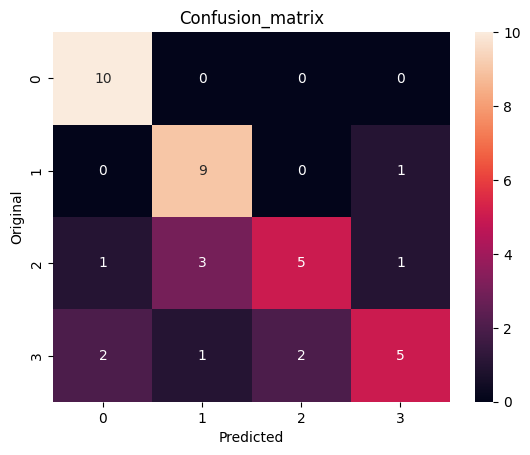

In [89]:
# calculating confusion matrix
cm = confusion_matrix(np.asarray(original), np.asarray(prediction))
ax = plt.subplot()
sns.heatmap(cm, annot = True, ax = ax)

ax.set_xlabel('Predicted')
ax.set_ylabel('Original')
ax.set_title('Confusion_matrix')